# Twitter Sentiment Analysis for Stock Investment


**Claire Zhao Sun**
- Matrikelnummer: 3630998
- Msc. Scientific Computing, Heidelberg University
- pz237@stud.uni-heidelberg.de

**Last Modified: 2021.02.03**

References:
- Documentation: https://huggingface.co/transformers/model_doc/bert.html
- BERTweet: https://github.com/VinAIResearch/BERTweet
- Fine-tuning Tutorial: https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S#scrollTo=9aHyGuTFgyPO
- Dataloader: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class
-             https://towardsdatascience.com/building-efficient-custom-datasets-in-pytorch-2563b946fd9f
- CUDA out of Memory Error: https://github.com/pytorch/pytorch/issues/16417 



In [ ]:
# To increase Google RAM allocation
a  = []
while(1):
    a.append('1')

# After a minute or so, you will get a notification from Colab saying “Your session crashed.”
# This will be followed by a screen asking if you would like to switch to a high-RAM runtime.
# Click yes, and you will be upgraded to 25GB of RAM. 


In [1]:
# mount to googledrive
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/MyDrive/NLP"


Mounted at /content/drive
data  models  modules  output


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/NLP')

from modules.BERT_finetuning_SUN import TwitterTrainDataset, TwitterRawDataset,create_dataloader,SentimentClassifier_BERT,train_epoch,eval_model,predict_train,infer_raw,show_prediction_performance

#import importlib
#importlib.reload(sys.modules['modules.BERT_finetuning_SUN'])
#from modules.BERT_finetuning_SUN import TwitterTrainDataset, TwitterRawDataset,create_dataloader,SentimentClassifier_BERT,train_epoch,eval_model,predict_train,infer_raw,show_prediction_performance


In [3]:
!pip install transformers
!pip install emoji #required for BERTweet 


     |████████████████████████████████| 1.8MB 9.7MB/s 
     |████████████████████████████████| 890kB 41.3MB/s 
     |████████████████████████████████| 2.9MB 40.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=a99e93c92e6a993e496b990a129d36fd34548442bd886a2315f72f09ae366e53
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 133kB 10.8MB/s 


In [4]:
import numpy as np
import pandas as pd
import torch
import transformers
from sklearn.metrics import classification_report, confusion_matrix
import time
import gc
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# Runtime -> Change runtime type -> Hardware accelerator: GPU

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla K80


# Download pretrained BERT model from transformers

In [ ]:
# BERT base cased model: 12-layer, 768-hidden, 12-heads, 109M parameters.Trained on cased English text.
BERT_BASE_CASED = 'bert-base-cased'
bert_model = transformers.BertModel.from_pretrained(BERT_BASE_CASED)
tokenizer = transformers.BertTokenizer.from_pretrained(BERT_BASE_CASED)


In [16]:

# BERTweet is pre-trained for English Tweets based on the RoBERTa pre-training procedure, using the same model configuration as BERT-base.
BERTWEET = "vinai/bertweet-base"
bertweet = transformers.AutoModel.from_pretrained(BERTWEET)
tokenizer = transformers.AutoTokenizer.from_pretrained(BERTWEET, use_fast=False)


Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


# Set model hyperparameters

In [18]:
# Hyperparameters (ref: BERTweet: A pre-trained language model for English Tweets arXiv:2005.10200v2)

BATCH_SIZE = 32
MAX_LEN = 128   # training set max 67, but considering the tweet limit has increased from 140 to 280 characters in Nov 2017 and our training data was mostly pre-2016
N_CLASSES = 3   # positive, neutral and negative
EPOCHS = 20
learning_rate = 1e-5

#choice = 'bert_base'
choice = 'bertweet' 

if choice == 'bertweet':
    model_save = "/content/drive/MyDrive/NLP/models/bertweet_state.bin"

if choice == 'bert_base':
    model_save = "/content/drive/MyDrive/NLP/models/bertbase_state.bin"


# Load training dataset


In [19]:
#sentiment_to_label = {'negative':0, 'neutral': 1, 'positive':2}
#sentiments = ['negative', 'neutral', 'positive']

# Load preprocessed training data (already split into training/validation/test)
df_train = pd.read_csv("/content/drive/MyDrive/NLP/data/Twitter_train.csv",lineterminator='\n') # to fix ParserError:Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.
df_valid = pd.read_csv("/content/drive/MyDrive/NLP/data/Twitter_valid.csv")
df_test = pd.read_csv("/content/drive/MyDrive/NLP/data/Twitter_test.csv")


# Calculate class weights for cost sensitive training to deal with class imbalance
class_weights = np.bincount(df_train.label).sum() / (len(np.unique(df_train.label)) * np.bincount(df_train.label))
weights = torch.tensor(class_weights,dtype=torch.float)


# Create dataloaders
train_data_loader = create_dataloader(text=df_train['text_clean'].to_numpy(),label=df_train['label'].to_numpy(), training = True, tokenizer=tokenizer, max_len=MAX_LEN, batch_size=BATCH_SIZE)
val_data_loader = create_dataloader(text=df_valid['text_clean'].to_numpy(),label=df_valid['label'].to_numpy(), training = True, tokenizer=tokenizer, max_len=MAX_LEN, batch_size=BATCH_SIZE)
test_data_loader = create_dataloader(text=df_test['text_clean'].to_numpy(),label=df_test['label'].to_numpy(), training = True, tokenizer=tokenizer, max_len=MAX_LEN, batch_size=BATCH_SIZE)



In [24]:
# Set up model, optimizer and loss function
if choice == 'bertweet':
    model = SentimentClassifier_BERT(bertweet, N_CLASSES).to(device)
if choice == 'bert_base':
    model = SentimentClassifier_BERT(bert_model, N_CLASSES).to(device)

optimizer = transformers.AdamW(model.parameters(), lr=learning_rate, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = transformers.get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
loss_fn = torch.nn.CrossEntropyLoss(weight=weights.to(device)).to(device)


In [25]:
choice

'bertweet'

In [ ]:
# Trace anomaly for debugging; switching off during actual training - otherwise too much GPU memory
# torch.autograd.set_detect_anomaly(True)

# Model training and validation
history = defaultdict(list)
best_accuracy = 0
stop_patience = 5   # num of epochs for looking back to check accuracy improvement
stop_delta = 1e-3   # accuracy improvement sensitivity threshold for early stopping

for epoch in range(EPOCHS):
    # Collecting garbage and emptying cuda memory after each epoch help solving the CUDA out of memory error
    gc.collect()
    torch.cuda.empty_cache()

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    start_time = time.time()

    train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
    print(f'Training   loss: {train_loss:.3f}; Accuracy: {train_acc:.3f}')

    val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_valid))
    print(f'Validation loss: {val_loss:.3f}; Accuracy: {val_acc:.3f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    print(f'Time: {time.time() - start_time} s')
    print()
    
    # saving model
    if val_acc > best_accuracy: # only save the best performing model based on validation set
        torch.save(model.state_dict(), model_save)
        best_accuracy = val_acc

    # early stopping
    if epoch > stop_patience: 
        a = np.array(history['val_acc'])
        stop_early = np.all(a[-stop_patience:] - a[-stop_patience-1:-1] < stop_delta)
        if stop_early:
            print('Stopping early')
            break

# Save training history in case of google colab runtime disconnetion
history_save = f"/content/drive/MyDrive/NLP/models/{choice}.csv"
with open(history_save,'wb') as f:
    pickle.dump(history, f)


Epoch 1/20
----------
Training   loss: 1.077; Accuracy: 0.376
Validation loss: 1.052; Accuracy: 0.479
Time: 370.1814913749695 s

Epoch 2/20
----------
Training   loss: 1.031; Accuracy: 0.426
Validation loss: 1.023; Accuracy: 0.508
Time: 378.2913911342621 s

Epoch 3/20
----------
Training   loss: 0.968; Accuracy: 0.494
Validation loss: 0.986; Accuracy: 0.507
Time: 378.3696172237396 s

Epoch 4/20
----------
Training   loss: 0.891; Accuracy: 0.558
Validation loss: 0.973; Accuracy: 0.536
Time: 378.6233904361725 s

Epoch 5/20
----------
Training   loss: 0.818; Accuracy: 0.608
Validation loss: 1.019; Accuracy: 0.548
Time: 378.3228130340576 s

Epoch 6/20
----------
Training   loss: 0.751; Accuracy: 0.641
Validation loss: 1.087; Accuracy: 0.554
Time: 378.46729803085327 s

Epoch 7/20
----------
Training   loss: 0.696; Accuracy: 0.684
Validation loss: 1.132; Accuracy: 0.556
Time: 378.83109498023987 s

Epoch 8/20
----------
Training   loss: 0.630; Accuracy: 0.714
Validation loss: 1.279; Accuracy:

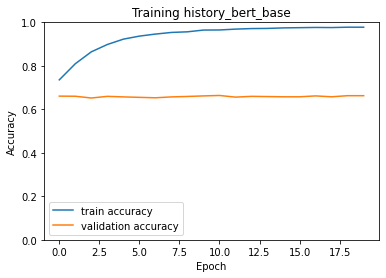

In [ ]:
# BERT_BASE [KEEP]
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history_'+choice)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

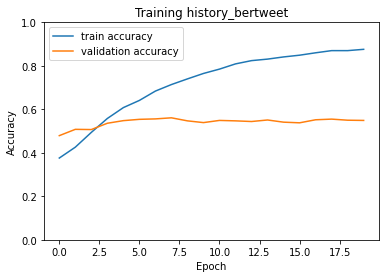

In [21]:
# BERTWEET [Keep]

#history={}
#history['train_acc']= [0.376,0.426,0.494,0.558,0.608,0.641,0.684,0.714,0.740,0.765,0.785,0.809,0.824,0.831,0.841,0.849,0.860,0.870,0.870,0.876]
#history['val_acc']  = [0.479,0.508,0.507,0.536,0.548,0.554,0.556,0.561,0.547,0.539,0.549,0.547,0.544,0.551,0.541,0.538,0.552,0.555,0.550,0.549]

plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history_'+choice)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
# BERTWEET with its own normalizer[TO RE-RUN]

plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history_'+choice)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

# Preparing model for test set

In [22]:
# reload the best model

if choice == 'bertweet':
    model = SentimentClassifier_BERT(bertweet, N_CLASSES).to(device)
if choice == 'bert_base':
    model = SentimentClassifier_BERT(bert_model, N_CLASSES).to(device)

model.load_state_dict(torch.load(model_save))
model = model.to(device)


Performance of bert_base model on Test Dataset


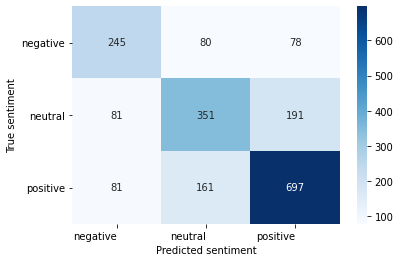

              precision    recall  f1-score   support

    negative       0.60      0.61      0.60       403
     neutral       0.59      0.56      0.58       623
    positive       0.72      0.74      0.73       939

    accuracy                           0.66      1965
   macro avg       0.64      0.64      0.64      1965
weighted avg       0.66      0.66      0.66      1965



In [ ]:
# model testing - BERT_BASE [KEEP]
print(f'Performance of {choice} model on Test Dataset')

test_acc, _ = eval_model(model, test_data_loader, loss_fn, device, len(df_test))
test_acc.item()

y_texts, y_pred, y_pred_probs, y_label = predict_train(model, test_data_loader,device)
show_prediction_performance(y_label, y_pred)


Performance of bertweet model on Test Dataset


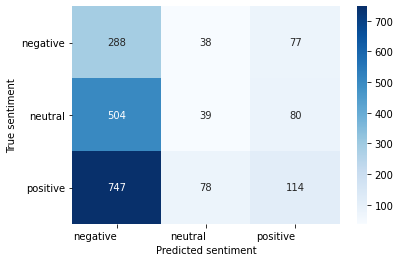

              precision    recall  f1-score   support

    negative       0.19      0.71      0.30       403
     neutral       0.25      0.06      0.10       623
    positive       0.42      0.12      0.19       939

    accuracy                           0.22      1965
   macro avg       0.29      0.30      0.20      1965
weighted avg       0.32      0.22      0.18      1965



In [26]:
# model testing - BERTWEET [KEEP]
print(f'Performance of {choice} model on Test Dataset')

test_acc, _ = eval_model(model, test_data_loader, loss_fn, device, len(df_test))
test_acc.item()

y_texts, y_pred, y_pred_probs, y_label = predict_train(model, test_data_loader,device)
show_prediction_performance(y_label, y_pred)


In [ ]:
# model testing - BERTWEET with its own normalization [To RERUN]

print(f'Performance of {choice} model on Test Dataset')

test_acc, _ = eval_model(model, test_data_loader, loss_fn, device, len(df_test))
test_acc.item()

y_texts, y_pred, y_pred_probs, y_label = predict_train(model, test_data_loader,device)
show_prediction_performance(y_label, y_pred)


# Save prediction outputs to dataset for ensemble

In [27]:
# Prepare datasets for ensemble model

#sentiment_to_label = {'negative':0, 'neutral': 1, 'positive':2}
# Convert predicted sentiment to class label

#for i in ['pred_Count_word_NB_balancedWeight','pred_Tfidf_word_LR_balancedWeight','pred_Word2Vec_news300_aggMean_SVM_balancedWeight']:
#    df_train[i+'_label'] = df_train[i].apply(lambda x: sentiment_to_label[x]).astype(int)
#    df_valid[i+'_label'] = df_valid[i].apply(lambda x: sentiment_to_label[x]).astype(int)
#    df_test[i+'_label'] = df_test[i].apply(lambda x: sentiment_to_label[x]).astype(int)


sentiments = ['negative','neutral','positive']
# Convert predicted class label to sentiment

#df_test[choice+'_sentiment']= y_pred.apply(lambda x: sentiments[x])
df_test[choice+'_label']=y_pred
#df_test[choice+'_pred_probs']=y_pred_probs

y_texts, y_pred, y_pred_probs, y_label = predict_train(model, val_data_loader,device)
#df_valid[choice+'_sentiment']= y_pred.apply(lambda x: sentiments[x])
df_valid[choice+'_label']=y_pred
#df_valid[choice+'_pred_probs']=y_pred_probs

y_texts, y_pred, y_pred_probs, y_label = predict_train(model, train_data_loader,device)
#df_train[choice+'_sentiment']= y_pred.apply(lambda x: sentiments[x])
df_train[choice+'_label']=y_pred
#df_train[choice+'_pred_probs']=y_pred_probs


df_train.to_csv('/content/drive/MyDrive/NLP/data/Twitter_train.csv',index=False)
df_valid.to_csv('/content/drive/MyDrive/NLP/data/Twitter_valid.csv',index=False)
df_test.to_csv('/content/drive/MyDrive/NLP/data/Twitter_test.csv',index=False)


In [28]:
df_train.columns

Index(['id', 'text', 'sentiment', 'text_unicode', 'text_clean', 'token_counts',
       'label', 'Vader_score', 'Vader_sentiment', 'Vader_label',
       'pred_Count_word_NB_balancedWeight',
       'pred_Tfidf_word_LR_balancedWeight',
       'pred_Word2Vec_news300_aggMean_SVM_balancedWeight',
       'pred_Count_word_NB_balancedWeight_label',
       'pred_Tfidf_word_LR_balancedWeight_label',
       'pred_Word2Vec_news300_aggMean_SVM_balancedWeight_label',
       'bert_base_label', 'bertweet_label'],
      dtype='object')

# Ensemble Models

Performance of majority vote by selected models on Training Set


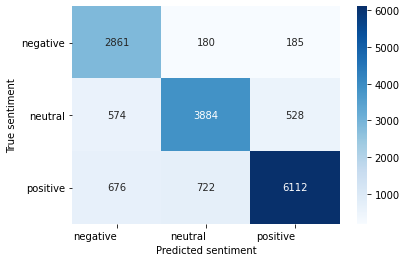

              precision    recall  f1-score   support

    negative       0.70      0.89      0.78      3226
     neutral       0.81      0.78      0.79      4986
    positive       0.90      0.81      0.85      7510

    accuracy                           0.82     15722
   macro avg       0.80      0.83      0.81     15722
weighted avg       0.83      0.82      0.82     15722

Performance of majority vote by selected models on Validation Set


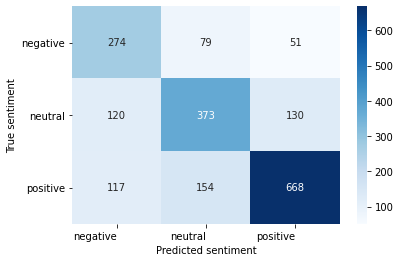

              precision    recall  f1-score   support

    negative       0.54      0.68      0.60       404
     neutral       0.62      0.60      0.61       623
    positive       0.79      0.71      0.75       939

    accuracy                           0.67      1966
   macro avg       0.65      0.66      0.65      1966
weighted avg       0.68      0.67      0.67      1966

Performance of majority vote by selected models on Test Set


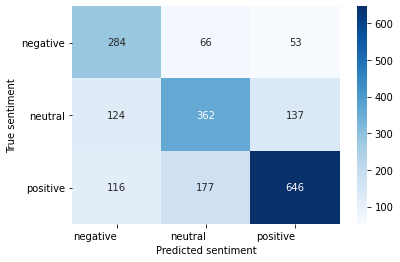

              precision    recall  f1-score   support

    negative       0.54      0.70      0.61       403
     neutral       0.60      0.58      0.59       623
    positive       0.77      0.69      0.73       939

    accuracy                           0.66      1965
   macro avg       0.64      0.66      0.64      1965
weighted avg       0.67      0.66      0.66      1965



In [113]:
# Simple Majority Vote

selected = ['bert_base_label','Vader_label','pred_Count_word_NB_balancedWeight_label','pred_Tfidf_word_LR_balancedWeight_label','pred_Word2Vec_news300_aggMean_SVM_balancedWeight_label']

print(f'Performance of majority vote by selected models on Training Set')
df_train['majority_label'] = df_train[selected].mode(axis=1)[0].astype(int)
show_prediction_performance(df_train['sentiment'], df_train['majority_label'].apply(lambda x: sentiments[x]))

print(f'Performance of majority vote by selected models on Validation Set')
df_valid['majority_label'] = df_valid[selected].mode(axis=1)[0].astype(int)
show_prediction_performance(df_valid['sentiment'], df_valid['majority_label'].apply(lambda x: sentiments[x]))

print(f'Performance of majority vote by selected models on Test Set')
df_test['majority_label'] = df_test[selected].mode(axis=1)[0].astype(int)
show_prediction_performance(df_test['sentiment'], df_test['majority_label'].apply(lambda x: sentiments[x]))


**OBSERVATION:** 
- Ensemble by majority vote does not improve the overall macro average f1 scores in validation (65%) and test set (64%) in a meaningful way from the selected best performing submodels (*BERT_BASE 64%, SVM_W2V 61%, LR_Tfidf 60%, NB_Count 59%, Vader 53%*)

In [100]:
# Definition to be moved to BERT_finetuning.py

class Ensemble(torch.nn.Module):
    def __init__(self,n):
        super(Ensemble, self).__init__()
        self.fc = torch.nn.Linear(n, 3)
        self.softmax = torch.nn.LogSoftmax()

    def forward(self, x):
        x = self.fc(x)
        out = self.softmax(x)
        return out  

ensemble = Ensemble(len(selected)).to(device)

criterion = torch.nn.CrossEntropyLoss().to(device)

optimizer = torch.optim.SGD(ensemble.parameters(), lr=1e-3, momentum=0.9)

epochs = 200
bs = 64



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/200
----------
Training loss: 0.944 
Training Acc: 0.475
Validation Acc: 0.513
Time: 0.3255882263183594 s

Epoch 21/200
----------
Training loss: 0.371 
Training Acc: 0.970
Validation Acc: 0.652
Time: 0.30869603157043457 s

Epoch 41/200
----------
Training loss: 0.298 
Training Acc: 0.972
Validation Acc: 0.652
Time: 0.3065197467803955 s

Epoch 61/200
----------
Training loss: 0.267 
Training Acc: 0.978
Validation Acc: 0.657
Time: 0.3149445056915283 s

Epoch 81/200
----------
Training loss: 0.252 
Training Acc: 0.982
Validation Acc: 0.663
Time: 0.2929220199584961 s

Epoch 101/200
----------
Training loss: 0.243 
Training Acc: 0.982
Validation Acc: 0.663
Time: 0.2933685779571533 s

Epoch 121/200
----------
Training loss: 0.238 
Training Acc: 0.982
Validation Acc: 0.663
Time: 0.3105635643005371 s

Epoch 141/200
----------
Training loss: 0.235 
Training Acc: 0.982
Validation Acc: 0.663
Time: 0.3027477264404297 s

Epoch 161/200
----------
Training loss: 0.233 
Training Acc: 0.982
Va

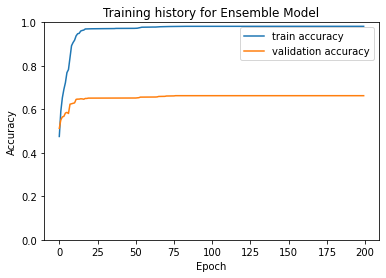

In [103]:
x_train = torch.tensor(df_train[selected].values).to(device,dtype=torch.float)  # input to model has to be float
x_valid = torch.tensor(df_valid[selected].values).to(device,dtype=torch.float) 
y_train = torch.tensor(df_train['label'].values).to(device,dtype=torch.long) # torch.long = loss function RuntimeError: "host_softmax" not implemented for 'Long'
y_valid = torch.tensor(df_valid['label'].values).to(device,dtype=torch.long)

history = defaultdict(list)

for epoch in range(epochs):

    ensemble.train()
    losses = []
    correct_predictions = 0

    start_time = time.time()

    for i in range((len(x_train) - 1) // bs + 1):
        optimizer.zero_grad()

        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]

        output = ensemble(xb)
        loss = criterion(output, yb) # pass the model output directly (torch.float), target should be torch.long

        _, pred = torch.max(output, dim=1)
        correct_predictions += torch.sum(pred == yb)
        losses.append(loss.item())
    
        loss.backward()
        optimizer.step()
    
    train_acc = correct_predictions / len(y_train) 
    train_loss = np.mean(losses)

    ensemble.eval()
    output = ensemble(x_valid)
    _, pred = torch.max(output, dim=1)
    val_acc = torch.sum(pred == y_valid) / len(y_valid) 
    
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
    if epoch%20 ==0:
        print(f'Epoch {epoch+1}/{epochs}')
        print('-' * 10)
        print(f'Training loss: {train_loss:.3f} \nTraining Acc: {train_acc:.3f}')
        print(f'Validation Acc: {val_acc:.3f}')
        print(f'Time: {time.time() - start_time} s')
        print()
    
# Visualization
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history for Ensemble Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [104]:
# save ensemble model
ensemble_save = "/content/drive/MyDrive/NLP/models/ensemble_state.bin"
torch.save(ensemble.state_dict(), ensemble_save)



Performance of Ensemble Model on Test Set


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


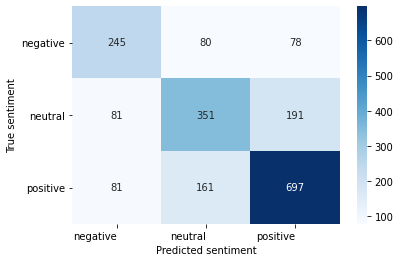

              precision    recall  f1-score   support

    negative       0.60      0.61      0.60       403
     neutral       0.59      0.56      0.58       623
    positive       0.72      0.74      0.73       939

    accuracy                           0.66      1965
   macro avg       0.64      0.64      0.64      1965
weighted avg       0.66      0.66      0.66      1965



In [107]:
# model testing

print(f'Performance of Ensemble Model on Test Set')

x_test = torch.tensor(df_test[selected].values).to(device,dtype=torch.float) 
ensemble.eval()
output = ensemble(x_test)
_, pred = torch.max(output, dim=1)
df_test['ensemble_label'] = pred.cpu()

show_prediction_performance(df_test['sentiment'], df_test['ensemble_label'].apply(lambda x: sentiments[x]))


In [110]:
# save ensemble predictions to datasets

ensemble.eval()
output = ensemble(x_train)
_, pred = torch.max(output, dim=1)
df_train['ensemble_label'] = pred.cpu()

output = ensemble(x_valid)
_, pred = torch.max(output, dim=1)
df_valid['ensemble_label'] = pred.cpu()

df_train.to_csv('/content/drive/MyDrive/NLP/data/Twitter_train.csv',index=False)
df_valid.to_csv('/content/drive/MyDrive/NLP/data/Twitter_valid.csv',index=False)
df_test.to_csv('/content/drive/MyDrive/NLP/data/Twitter_test.csv',index=False)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


**OBSERVATION:** 
- Ensemble model with one single layer NN does not improve the overall macro average f1 scores (64%); similar performance as majority vote and not better than best performing submodels (*BERT_BASE 64%, SVM_W2V 61%, LR_Tfidf 60%, NB_Count 59%, Vader 53%*)

In [171]:
# try a different ensemble model architecture

class Ensemble2(torch.nn.Module):
    def __init__(self,n,h):
        super(Ensemble2, self).__init__()
        self.n = n
        self.conv = torch.nn.Conv1d(n, n, 1) # effectively serves as a selection layer
        self.fc1 = torch.nn.Linear(n, h) # h=hidden_state
        self.fc2 = torch.nn.Linear(h, 3)
        self.softmax = torch.nn.LogSoftmax()

    def forward(self, x):
        x = x.unsqueeze(-1)
        x = self.conv(x)
        x = self.fc1(x.view(-1, self.n))
        x = self.fc2(x)
        out = self.softmax(x)
        return out 



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1/100
----------
Training loss: 0.945 
Training Acc: 0.453
Validation Acc: 0.483
Time: 8.81073522567749 s

Epoch 21/100
----------
Training loss: 0.232 
Training Acc: 0.982
Validation Acc: 0.663
Time: 8.7714102268219 s

Epoch 41/100
----------
Training loss: 0.229 
Training Acc: 0.982
Validation Acc: 0.663
Time: 8.773540258407593 s

Epoch 61/100
----------
Training loss: 0.229 
Training Acc: 0.982
Validation Acc: 0.663
Time: 8.791311264038086 s

Epoch 81/100
----------
Training loss: 0.228 
Training Acc: 0.982
Validation Acc: 0.663
Time: 8.837198495864868 s



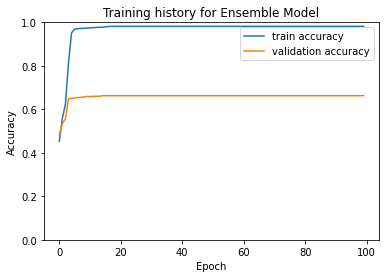

In [172]:
torch.autograd.set_detect_anomaly(True)

hidden_states = 50 
ensemble = Ensemble2(len(selected),hidden_states).to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(ensemble.parameters(), lr=1e-4, momentum=0.9)
epochs = 100
bs = 16

x_train = torch.tensor(df_train[selected].values).to(device,dtype=torch.float)  # input to model has to be float
x_valid = torch.tensor(df_valid[selected].values).to(device,dtype=torch.float) 
y_train = torch.tensor(df_train['label'].values).to(device,dtype=torch.long) # torch.long = loss function RuntimeError: "host_softmax" not implemented for 'Long'
y_valid = torch.tensor(df_valid['label'].values).to(device,dtype=torch.long)

history = defaultdict(list)

for epoch in range(epochs):

    ensemble.train()
    losses = []
    correct_predictions = 0

    start_time = time.time()

    for i in range((len(x_train) - 1) // bs + 1):
        optimizer.zero_grad()

        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]

        output = ensemble(xb)
        loss = criterion(output, yb) # pass the model output directly (torch.float), target should be torch.long

        _, pred = torch.max(output, dim=1)
        correct_predictions += torch.sum(pred == yb)
        losses.append(loss.item())
    
        loss.backward()
        optimizer.step()
    
    train_acc = correct_predictions / len(y_train) 
    train_loss = np.mean(losses)

    ensemble.eval()
    output = ensemble(x_valid)
    _, pred = torch.max(output, dim=1)
    val_acc = torch.sum(pred == y_valid) / len(y_valid) 
    
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
    if epoch%20 ==0:
        print(f'Epoch {epoch+1}/{epochs}')
        print('-' * 10)
        print(f'Training loss: {train_loss:.3f} \nTraining Acc: {train_acc:.3f}')
        print(f'Validation Acc: {val_acc:.3f}')
        print(f'Time: {time.time() - start_time} s')
        print()
    
# Visualization
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history for Ensemble Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);


Performance of Ensemble2 Model on Test Set


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


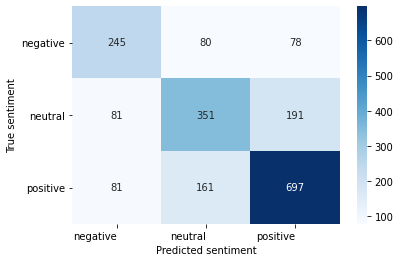

              precision    recall  f1-score   support

    negative       0.60      0.61      0.60       403
     neutral       0.59      0.56      0.58       623
    positive       0.72      0.74      0.73       939

    accuracy                           0.66      1965
   macro avg       0.64      0.64      0.64      1965
weighted avg       0.66      0.66      0.66      1965



In [173]:
# model testing

print(f'Performance of Ensemble2 Model on Test Set')

x_test = torch.tensor(df_test[selected].values).to(device,dtype=torch.float) 
ensemble.eval()
output = ensemble(x_test)
_, pred = torch.max(output, dim=1)
df_test['ensemble2_label'] = pred.cpu()

show_prediction_performance(df_test['sentiment'], df_test['ensemble2_label'].apply(lambda x: sentiments[x]))


In [176]:
ensemble

Ensemble2(
  (conv): Conv1d(5, 5, kernel_size=(1,), stride=(1,))
  (fc1): Linear(in_features=5, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=3, bias=True)
  (softmax): LogSoftmax(dim=None)
)

In [174]:

# save ensemble model
ensemble_save = "/content/drive/MyDrive/NLP/models/ensemble2_state.bin"
torch.save(ensemble.state_dict(), ensemble_save)


# save ensemble predictions to datasets
ensemble.eval()

output = ensemble(x_train)
_, pred = torch.max(output, dim=1)
df_train['ensemble2_label'] = pred.cpu()

output = ensemble(x_valid)
_, pred = torch.max(output, dim=1)
df_valid['ensemble2_label'] = pred.cpu()

df_train.to_csv('/content/drive/MyDrive/NLP/data/Twitter_train.csv',index=False)
df_valid.to_csv('/content/drive/MyDrive/NLP/data/Twitter_valid.csv',index=False)
df_test.to_csv('/content/drive/MyDrive/NLP/data/Twitter_test.csv',index=False)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


**OBSERVATION:** 
- Same conclusion as before: it seems the ensemble model with modified architecture (1D convolution + fully connected layers) does not improve the overall macro average f1 scores (64%) either; similar performance as previous simple emsemble model as well as the majority vote, and not better than best performing submodels (*BERT_BASE 64%, SVM_W2V 61%, LR_Tfidf 60%, NB_Count 59%, Vader 53%*) - no free lunch?

- It seems that some missclassifications are consistent throught out all models, therefore by combining different models we do not gain extra perfomance improvement (since they predicted wrong). 

(Index(['id', 'text', 'sentiment', 'text_unicode', 'text_clean', 'token_counts',
        'label', 'Vader_score', 'Vader_sentiment', 'Vader_label',
        'pred_Count_word_NB_balancedWeight',
        'pred_Tfidf_word_LR_balancedWeight',
        'pred_Word2Vec_news300_aggMean_SVM_balancedWeight',
        'pred_Count_word_NB_balancedWeight_label',
        'pred_Tfidf_word_LR_balancedWeight_label',
        'pred_Word2Vec_news300_aggMean_SVM_balancedWeight_label',
        'bert_base_label', 'bertweet_label', 'majority_label', 'ensemble_label',
        'ensemble2_label'],
       dtype='object'),
 Index(['id', 'text', 'sentiment', 'text_unicode', 'text_clean', 'token_counts',
        'label', 'Vader_score', 'Vader_sentiment', 'Vader_label',
        'pred_Count_word_NB_balancedWeight',
        'pred_Tfidf_word_LR_balancedWeight',
        'pred_Word2Vec_news300_aggMean_SVM_balancedWeight',
        'pred_Count_word_NB_balancedWeight_label',
        'pred_Tfidf_word_LR_balancedWeight_label',
   

Comparison of Model Performances


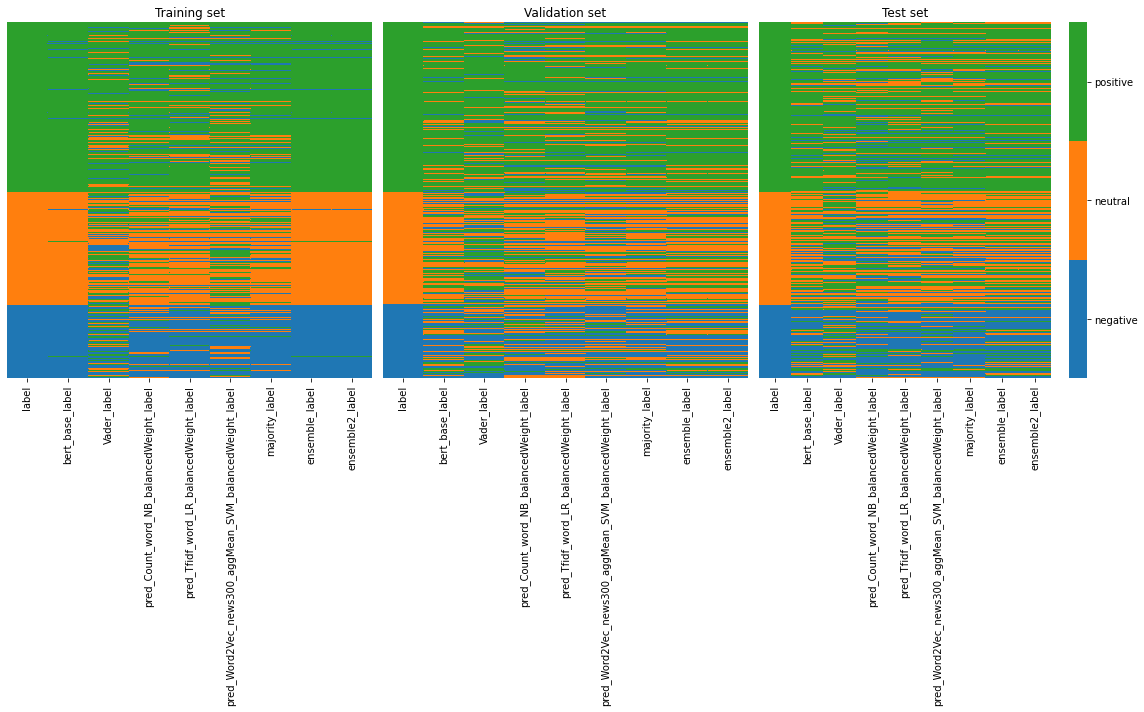

In [193]:
# Visualization of model performances
print("Comparison of Model Performances")

cmap = sns.color_palette("tab10", 3)
ensembles = ['majority_label','ensemble_label','ensemble2_label']

fig, ax = plt.subplots(1,3,figsize=(16,10),tight_layout=True)

a = sns.heatmap(df_train[['label']+selected+ensembles].sort_values(by='label',ascending=False), cmap=cmap,yticklabels=False,ax=ax[0],cbar=False)
a.set_title('Training set')
a = sns.heatmap(df_valid[['label']+selected+ensembles].sort_values(by='label',ascending=False), cmap=cmap,yticklabels=False,ax=ax[1],cbar=False)
a.set_title('Validation set')
a = sns.heatmap(df_test[['label']+selected+ensembles].sort_values(by='label',ascending=False), cmap=cmap,yticklabels=False,ax=ax[2])
a.set_title('Test set')

colorbar = a.collections[0].colorbar
r = colorbar.vmax - colorbar.vmin
colorbar.set_ticks([colorbar.vmin + r / 3 * (0.5 + i) for i in range(3)])
colorbar.set_ticklabels(sentiments)


**OBSERVATION:** 
- As expected, the two ensemble models converge to BERT_Base model during training and their maximum performance is limited by BERT_BASE.

- In addition, all or majority of submodels sometimes tend to agree with each other on certain classifications, however, this might be different from the ground truth, which further limited the ensemble model's performance upside.

- Overall we face the challenge of class imbalance: majority class (positive) has better performances than minority classe (negative). 

===================================================================================================================